# Steam平台游戏数据分析

## 作者

* 190207132 单元琛
    - 数据搜索、数据处理、可视化分析、报告整理
* 190207029 陈凯
    - 海报制作、报告整理

## 问题描述

通过研究近年来Steam中游戏的价格和日期、评价等因素，
并进行可视化处理，从而得出不同价格区间游戏的一些共性及特性

## 数据来源

[kaggle - Steam games complete dataset](https://www.kaggle.com/trolukovich/steam-games-complete-dataset)

## 数据处理

In [1]:
# 导入需要的库
import re
import datetime
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 增加中文显示
plt.rcParams['font.sans-serif'].insert(0, 'Microsoft YaHei')

In [3]:
# 读取数据
df = pd.read_csv('..\data\steam_games.csv')
df = df[df.types == 'app']

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-3-b1f832232e64>:2: DeprecationWarning: invalid escape sequence \d
  df = pd.read_csv('..\data\steam_games.csv')


In [4]:
# 数据切片
df = df[['name','all_reviews','release_date',
         'publisher','genre','original_price',
         'game_description']]
df

,name,all_reviews,release_date,publisher,genre,original_price,game_description
0,DOOM,"Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016","Bethesda Softworks,Bethesda Softworks",Action,$19.99,"About This Game Developed by id software, the..."
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017","PUBG Corporation,PUBG Corporation","Action,Adventure,Massively Multiplayer",$29.99,About This Game PLAYERUNKNOWN'S BATTLEGROUND...
2,BATTLETECH,"Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018","Paradox Interactive,Paradox Interactive","Action,Adventure,Strategy",$39.99,About This Game From original BATTLETECH/Mec...
3,DayZ,"Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018","Bohemia Interactive,Bohemia Interactive","Action,Adventure,Massively Multiplayer",$44.99,About This Game The post-soviet country of Ch...
4,EVE Online,"Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003","CCP,CCP","Action,Free to Play,Massively Multiplayer,RPG,...",Free,About This Game
...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,NaN,"Feb 12, 2019",NaN,"Casual,Simulation",$2.99,"About This Content Play ""Ghost Division"" by S..."
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,NaN,"Feb 5, 2019",NaN,"Casual,Simulation",$2.99,"About This Content Play ""Trippin’ on a Hole i..."
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,NaN,"Jul 31, 2018",NaN,"Indie,RPG,Strategy",$7.99,About This Content Quests of Doom 4: A Midni...
40831,Mega Man X5 Sound Collection,NaN,"Jul 24, 2018","CAPCOM CO., LTD,CAPCOM CO., LTD",Action,$9.99,About This Content Get equipped with the stun...


In [5]:
# 数据信息统计
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38021 entries, 0 to 40832
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              38007 non-null  object
 1   all_reviews       28470 non-null  object
 2   release_date      37654 non-null  object
 3   publisher         33021 non-null  object
 4   genre             37625 non-null  object
 5   original_price    34999 non-null  object
 6   game_description  37920 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB


### 进行数据整理和填充

In [6]:
# 对价格填充
df.original_price.fillna(0, inplace=True)

# 对日期填充
df.release_date.fillna(method='bfill', inplace=True)

In [7]:
# 对日期处理
month_dic = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,
         'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,
         'Nov':11,'Dec':12}

def change_date(arr):
    try:
        result = re.findall(r'\w+',arr)
        month = int(month_dic[result[0]])
        day = int(result[1])
        year = int(result[2])
        return datetime.date(year,month,day)
    except (TypeError, KeyError, IndexError, ValueError):
        pass

df['release_date'] = df['release_date'].map(change_date)
df.release_date.fillna(method='bfill', inplace=True)

In [8]:
def gen_year(arr):
    return arr.year

def gen_month(arr):
    return arr.month

df['year'] = df['release_date'].map(gen_year)
df['month'] = df['release_date'].map(gen_month)

In [9]:
# 对价格进行处理
def change_price(arr):
    try:
        if re.match(r'\$.+', arr):
            return float(arr[1:])
        else:
            return 0
    except TypeError:
        return 0

df['original_price'] = df['original_price'].map(change_price)

In [10]:
# 对评论进行处理
def change_review(arr):
    try:
        match_obj = re.search(r',- \d+%', arr)
        return int(match_obj.group(0)[2:-1]) / 100.0
    except (TypeError, AttributeError):
        return np.random.randint(10, 80) / 100.0

df['all_reviews'] = df['all_reviews'].map(change_review)
df.all_reviews.fillna(method='pad', inplace=True)

In [11]:
# 对数据进行清洗
df.fillna('Unknown', inplace=True)
df = df[~df['name'].isin(['Unknown'])]
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38006 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              38006 non-null  object 
 1   all_reviews       38006 non-null  float64
 2   release_date      38006 non-null  object 
 3   publisher         38006 non-null  object 
 4   genre             38006 non-null  object 
 5   original_price    38006 non-null  float64
 6   game_description  38006 non-null  object 
 7   year              38006 non-null  int64  
 8   month             38006 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.9+ MB


In [12]:
# 更改列名
df.columns = ['Name', 'Review', 'Date', 'Publisher',
              'Genre', 'Price', 'Description', 'Year', 'Month']

### 对游戏介绍进行NLP，做出词云图

In [13]:
# 获取停用词列表
docList = []
with open('..\data\words.stop', 'r') as f:
    for line in f.readlines():
        if line != '':
            docList.append(line.strip())

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-13-9db416f0ea7a>:3: DeprecationWarning: invalid escape sequence \d
  with open('..\data\words.stop', 'r') as f:


In [14]:
# 导入词典
n_features = 1000
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words=docList,
                                max_df = 0.5,
                                min_df = 10)

In [15]:
# 转化为特征矩阵
tf = tf_vectorizer.fit_transform(df.Description)

In [16]:
# lda = LatentDirichletAllocation(n_components=8, max_iter=100,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)
# lda.fit(tf)
# joblib.dump(lda, '..\models\save.model')
lda = joblib.load('..\\models\\save.model')

In [17]:
# 获得每个主题排名靠前的词汇表
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=15)

Topic #0:
space vr ship use experience create planet 3d virtual features support alien reality using video
Topic #1:
music soundtrack tracks track theme original song play mp3 contains com files bonus edition guitar
Topic #2:
story world adventure puzzles characters fantasy time features explore solve games dark hidden journey mysterious
Topic #3:
scenarios train simulator car class route drive features cars racing available line realistic including vehicles
Topic #4:
players war battle player team combat enemy world multiplayer weapons campaign play missions map maps
Topic #5:
time world make like life people way need different don day build city survive work
Topic #6:
levels play mode level player features players different time gameplay games fun friends modes challenge
Topic #7:
enemies weapons unique items character fight world monsters different battle use abilities weapon boss powerful



In [ ]:
# pyLDAvis.enable_notebook()
# data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
# pyLDAvis.show(data)

In [17]:
tmp = []
for word in df.Description:
    tmp.append(word)
desc_join = ' '.join(str(i) for i in tmp)
desc_arr = re.findall(r'\w+',desc_join)
stop_word = ('This','About','in','in the','you will','you','will',
             'You','can','the','of','the','About This','to')
desc = ' '.join(str(i) for i in desc_arr)

In [18]:
from wordcloud import WordCloud, STOPWORDS

word_cloud = WordCloud(stopwords=STOPWORDS,
                       background_color='white'
                       ).generate_from_text(desc)

Populating the interactive namespace from numpy and matplotlib


c:\users\hasee\appdata\local\programs\python\python38\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


(-0.5, 399.5, 199.5, -0.5)

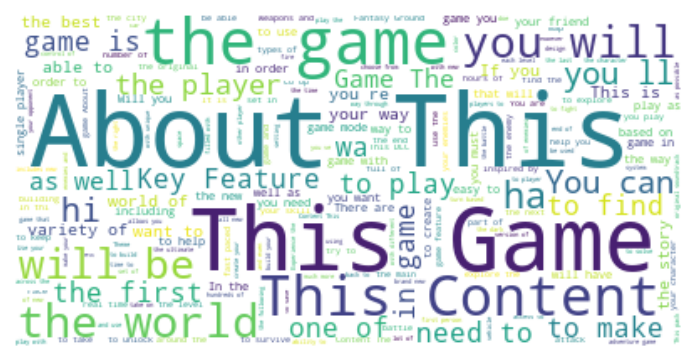

In [19]:
%pylab inline
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")

In [20]:
# 按价格分成四类
df_1 = df[df.Price == 0] # 免费游戏
df_2 = df[(df.Price > 0) & (df.Price <= 10)] # 10美元以内
df_3 = df[(df.Price > 10) & (df.Price <= 20)] # 10-20
df_4 = df[df.Price > 20] # 20+

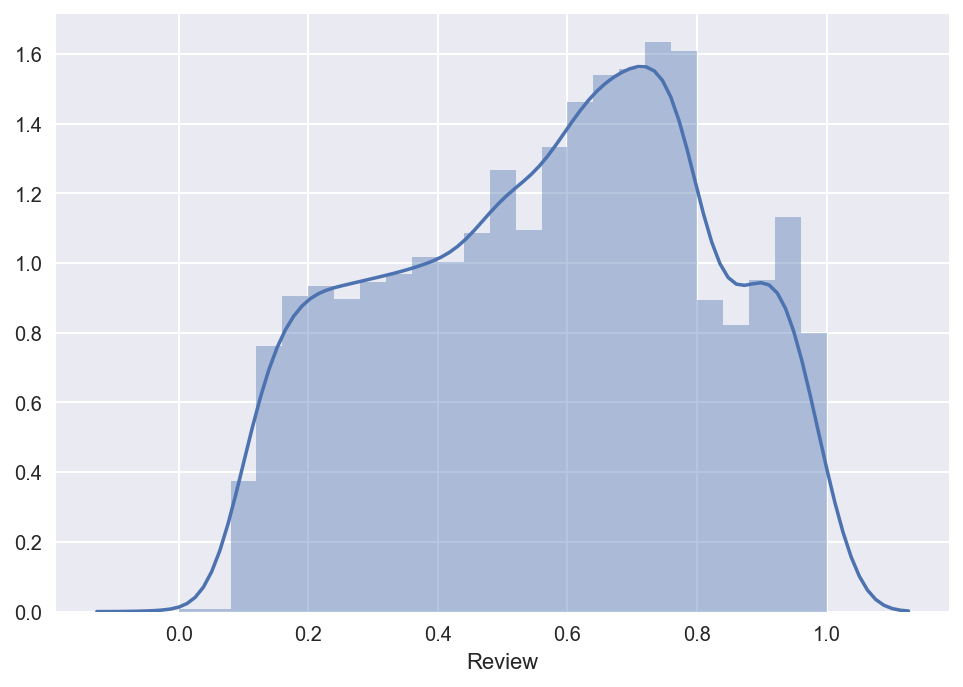

In [21]:
plt.style.use('seaborn')
sns.distplot(df_1.Review,kde=True)

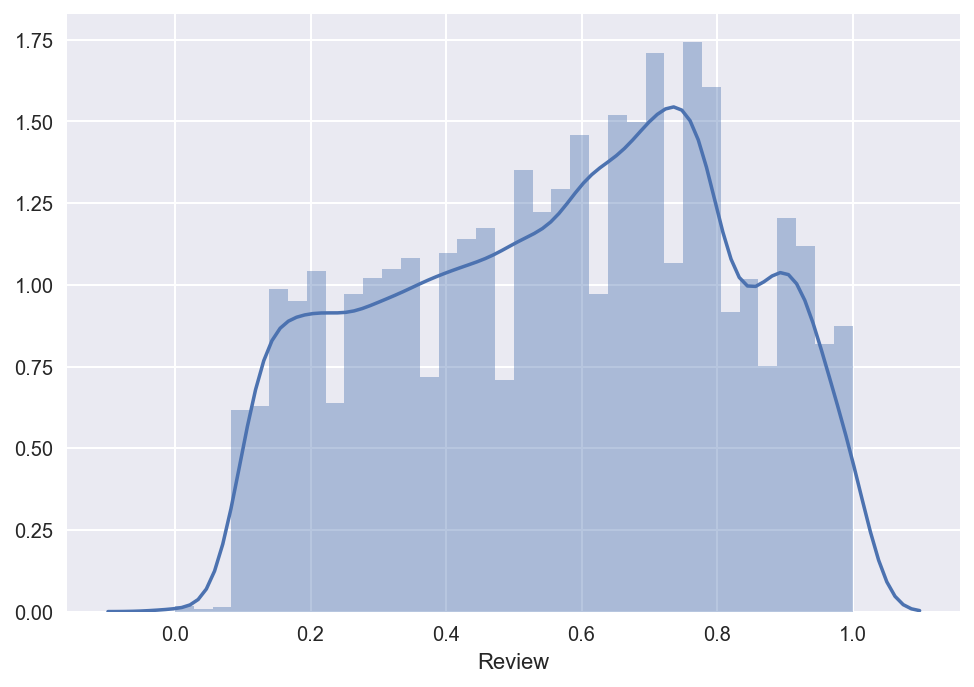

In [22]:
sns.distplot(df_2.Review,kde=True)

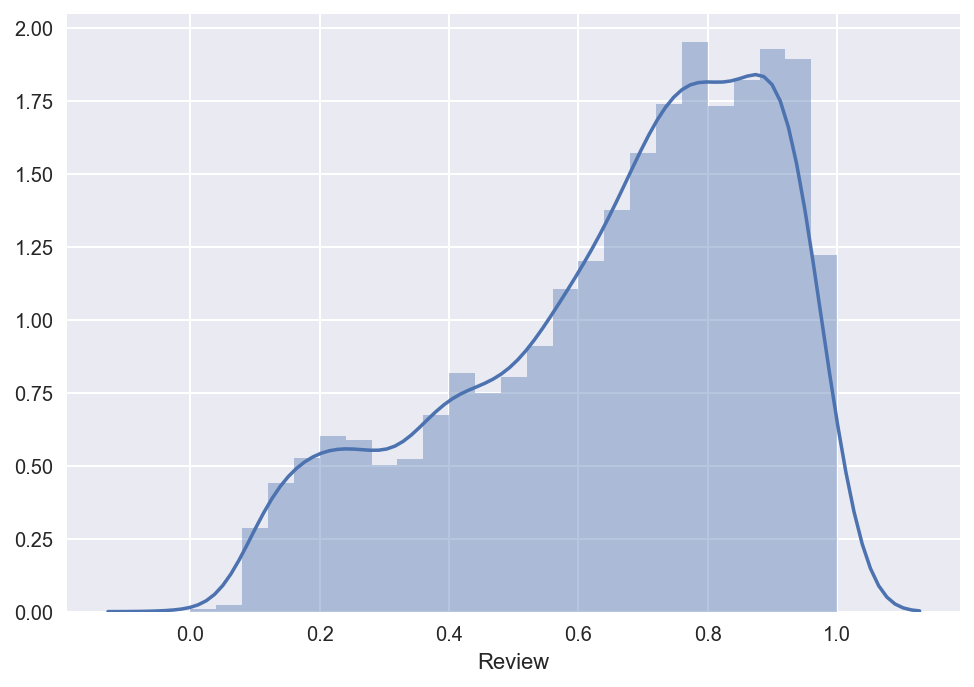

In [23]:
sns.distplot(df_3.Review,kde=True)

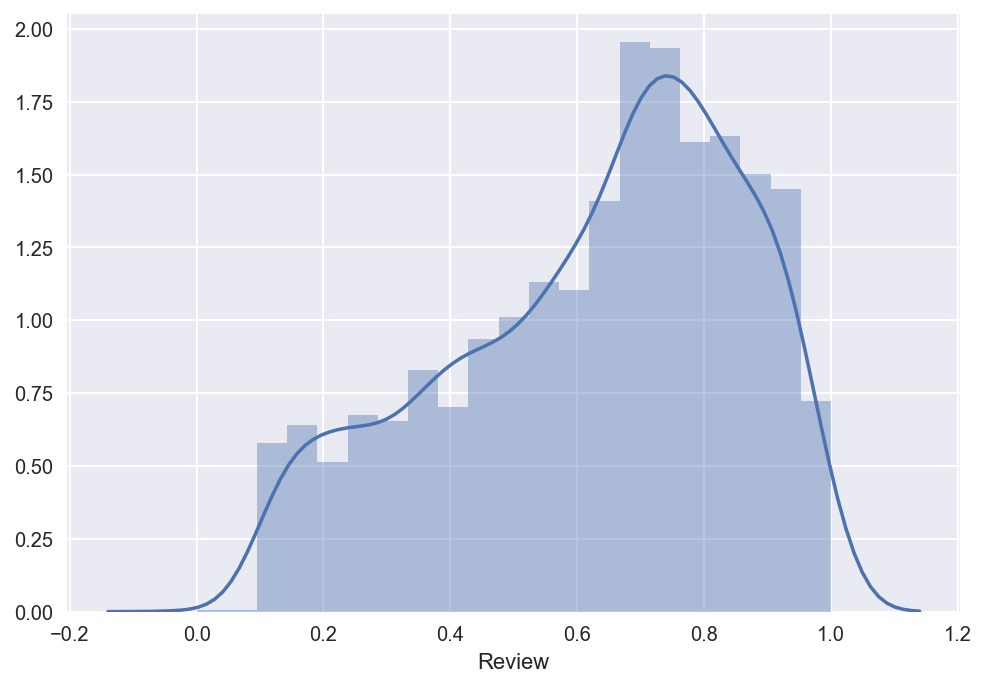

In [24]:
sns.distplot(df_4.Review,kde=True)

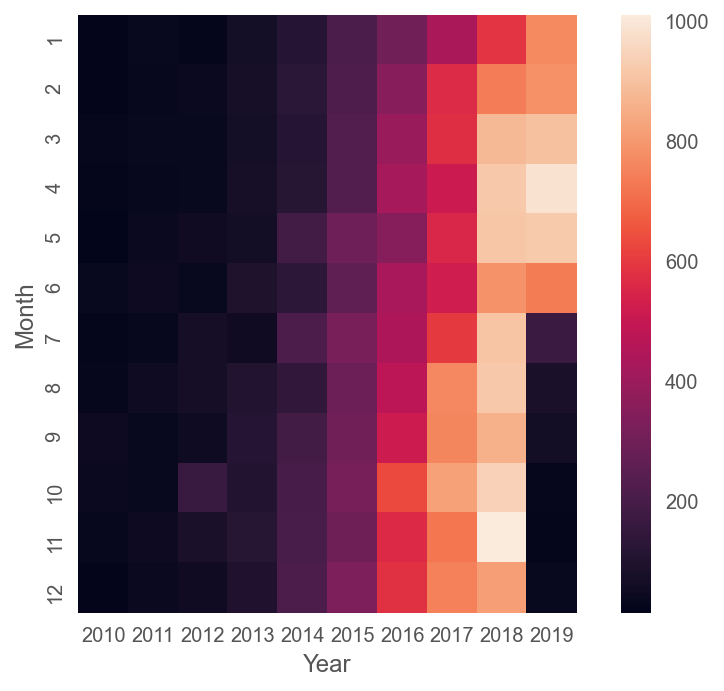

In [25]:
# 游戏发售时间热力图
plt.style.use('ggplot')
pivot = df[(df.Year > 2009) & (df.Year < 2020)].pivot_table(
        index='Month',columns='Year',
        aggfunc='count',values='Review')
sns.heatmap(pivot,square=True)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 3.000e+00,
        2.000e+00, 6.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        1.000e+01, 6.000e+00, 1.000e+01, 1.000e+01, 1.100e+01, 7.000e+00,
        9.000e+00, 1.000e+01, 1.500e+01, 2.400e+01, 2.000e+01, 3.100e+01,
        3.000e+01, 3.700e+01, 6.400e+01, 1.140e+02, 1.550e+02, 2.140e+02,
        2.170e+02, 2.710e+02, 3.570e+0

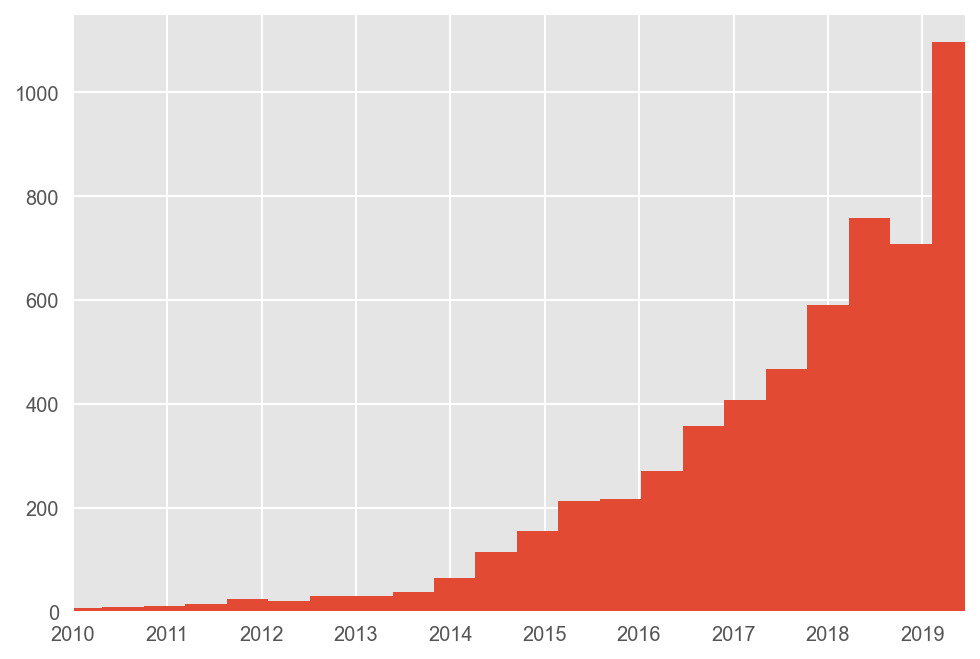

In [26]:
plt.xlim(datetime.date(2010,1,1),datetime.date(2019,6,18))
plt.hist(df_1.Date,bins=100)

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 6.000e+00, 1.000e+00, 7.000e+00,
        2.000e+00, 3.000e+00, 1.300e+01, 5.000e+00, 1.400e+01, 2.000e+00,
        1.500e+01, 4.000e+00, 1.300e+01, 8.000e+00, 1.100e+01, 2.300e+01,
        1.300e+01, 1.200e+01, 1.900e+01, 8.000e+00, 1.900e+01, 1.500e+01,
        1.000e+01, 1.300e+01, 1.600e+01, 1.900e+01, 1.400e+01, 2.000e+01,
        1.600e+01, 1.900e+01, 3.400e+01, 2.400e+01, 2.600e+01, 2.500e+01,
        2.100e+01, 2.200e+01, 2.600e+01, 5.100e+01, 2.800e+01, 4.100e+01,
        3.900e+01, 3.500e+01, 5.500e+01, 7.000e+01, 6.900e+01, 7.900e+01,
        7.900e+01, 1.180e+02, 1.320e+02, 1.450e+02, 1.280e+02, 1.660e+02,
        2.970e+02, 2.160e+02, 2.800e+02, 3.780e+02, 4.840e+02, 5.700e+02,
        7.240e+02, 9.620e+02, 1.052e+0

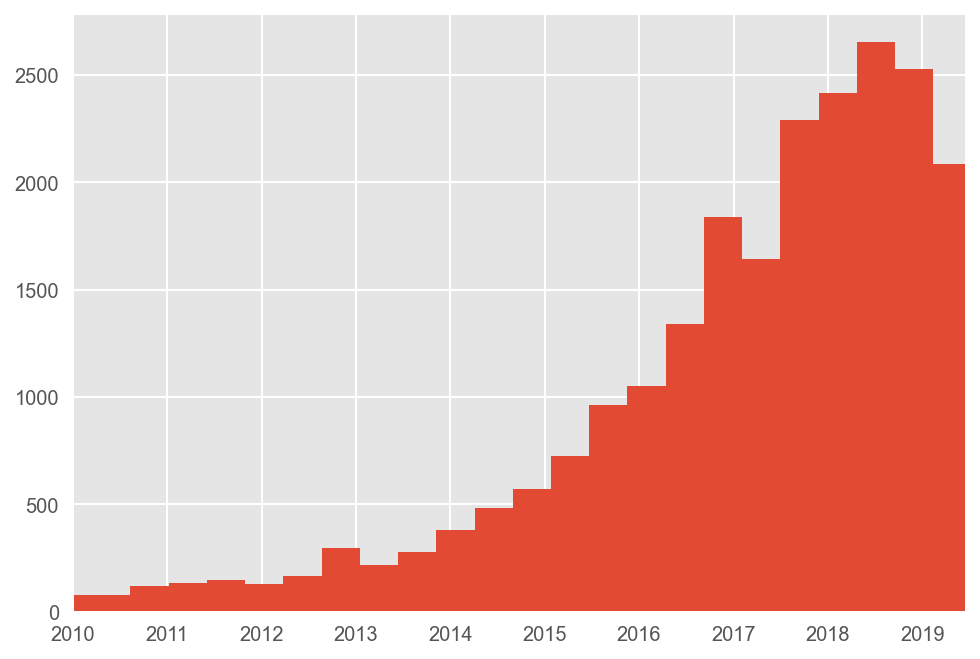

In [27]:
plt.xlim(datetime.date(2010,1,1),datetime.date(2019,6,18))
plt.hist(df_2.Date,bins=100)

(array([  1.,   0.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   4.,   0.,
          0.,   0.,   2.,   1.,   1.,   0.,   2.,   0.,   1.,   2.,   1.,
          2.,   1.,   1.,   2.,   2.,   1.,   2.,   0.,   4.,   3.,   2.,
          4.,   7.,   3.,   9.,   4.,   7.,   1.,   6.,   5.,   9.,   4.,
         12.,  12.,   6.,  12.,  21.,   7.,  20.,  16.,  20.,   9.,  14.,
         15.,  27.,  16.,  14.,  20.,  44.,  36.,  42.,  45.,  66.,  47.,
         78.,  78., 123.,  84., 118., 136., 137., 141., 198., 195., 239.,
        170., 278., 245., 282., 260., 315., 389., 426., 368., 373.,   6.,
          5.]),
 array([728196.  , 728288.29, 728380.58, 728472.87, 728565.16, 728657.45,
        728749.74, 728842.03, 728934.32, 729026.61, 729118.9 , 729211.19,
        729303.48, 729395.77, 729488.06, 729580.35, 729672.64, 729764.93,
        729857.22, 729949.51, 730041.8 , 730134.09, 730226.38, 730318.67,
        730410.96, 730

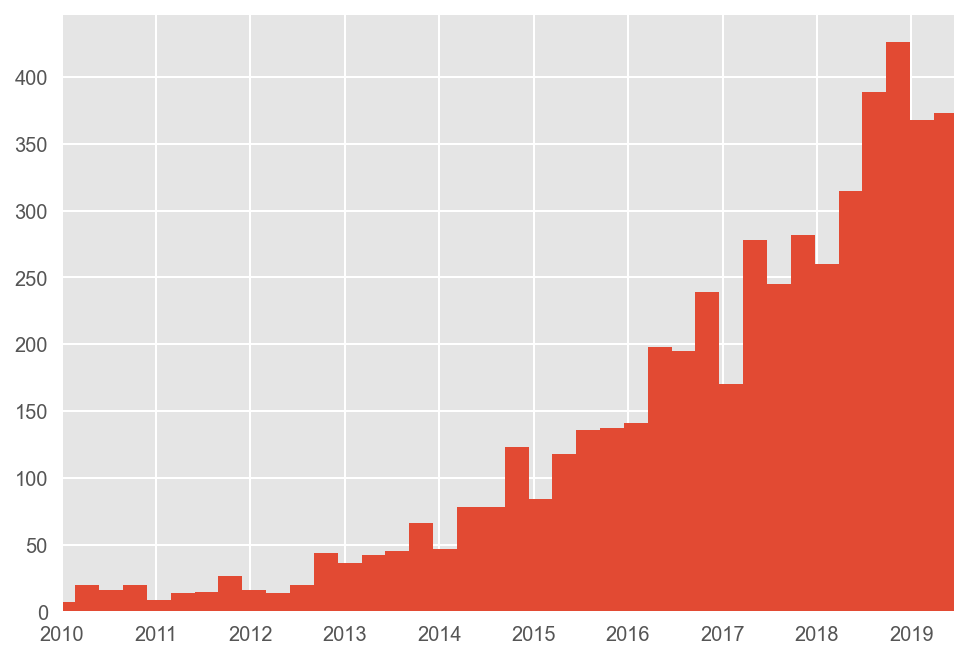

In [28]:
plt.xlim(datetime.date(2010,1,1),datetime.date(2019,6,18))
plt.hist(df_3.Date,bins=100)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   3.,   1.,   2.,   1.,   0.,   1.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   3.,   3.,   0.,   2.,   1.,   1.,   0.,   2.,
          2.,   8.,   5.,   8.,   6.,   7.,   6.,   4.,  12.,   5.,   5.,
         15.,  21.,  31.,  28.,  64.,  34.,  55.,  85.,  86.,  90., 101.,
        135., 130., 153., 188., 278., 266., 304., 337., 358., 242.,  10.,
          1.]),
 array([724642.  , 724770.88, 724899.76, 725028.64, 725157.52, 725286.4 ,
        725415.28, 725544.16, 725673.04, 725801.92, 725930.8 , 726059.68,
        726188.56, 726317.44, 726446.32, 726575.2 , 726704.08, 726832.96,
        726961.84, 727090.72, 727219.6 , 727348.48, 727477.36, 727606.24,
        727735.12, 727

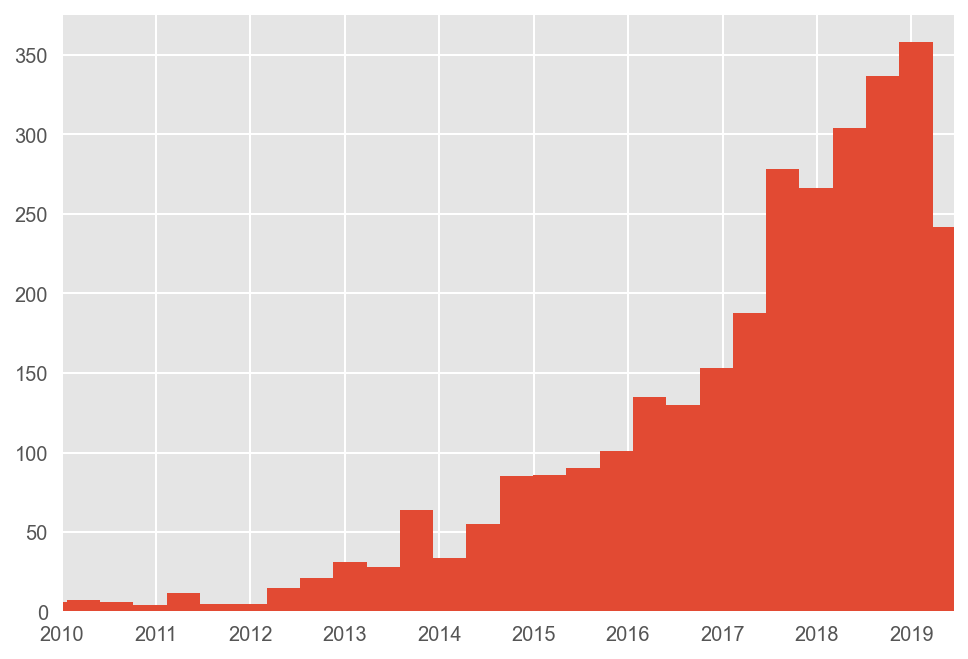

In [29]:
plt.xlim(datetime.date(2010,1,1),datetime.date(2019,6,18))
plt.hist(df_4.Date,bins=100)

In [30]:
# 对发行商进行数据分析，统计出哪些开发商更高产
pub = df.groupby('Publisher').count().sort_values(by='Review',ascending=False)
pub.Name[1:11]

Publisher
Degica,Degica                                            469
KOEI TECMO GAMES CO., LTD.,KOEI TECMO GAMES CO., LTD.    400
Ubisoft,Ubisoft                                          294
Dovetail Games - Trains,Dovetail Games - Trains          291
Paradox Interactive,Paradox Interactive                  269
Square Enix,Square Enix                                  228
SEGA,SEGA                                                216
Big Fish Games,Big Fish Games                            198
THQ Nordic,THQ Nordic                                    171
BANDAI NAMCO Entertainment,BANDAI NAMCO Entertainment    156
Name: Name, dtype: int64

## 数据分析与可视化

### 不同价格的游戏中类别、出版商、好评度、发行日期的比例分布

#### 免费游戏
#### 0-10\$
#### 10-20\$
#### 20\$+

### 汇总官方介绍中出现频率最高的词
